<h1> Possum Regression </h1>
https://www.kaggle.com/datasets/abrambeyer/openintro-possum?datasetId=1534513&sortBy=voteCount
<h2> Introduction </h2>

An objective of this work is to consolidate and use part of the knowledge gained from the book "Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow".

Our goal is to predict the age of given possum. The problem is supervised and multiple regression type. I will use batch learning, because there is no particular need to adjust to changing data rapidly, the dataset is small and there is no continous stream of data coming.

Root Mean Square Error (RMSE) as a performance measure is a common cost function in regression tasks, so that will be my choice.

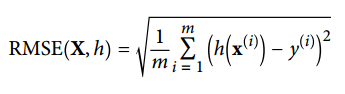

<h2> Libraries and settings</h2>

In [5]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from scipy import stats
from scipy.stats import wasserstein_distance
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from pprint import pprint

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor

%run ml_functions.ipynb
%run custom_transformers.ipynb

np.random.seed(42)

from IPython.display import Audio
sound_file = './sound/mixkit-game-notification-wave-alarm-987.wav'

<h2>Load the data <h2>

In [6]:
df = pd.read_csv('data/possum.csv')

<h3> Take a quick look </h3>

In [7]:
df.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [8]:
df.columns

Index(['case', 'site', 'Pop', 'sex', 'age', 'hdlngth', 'skullw', 'totlngth',
       'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly'],
      dtype='object')

In [9]:
df.shape

(104, 14)

There are 14 attributes including one dependent variable - 'age' and 104 instances. It means dataset is very small by ML standards.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case      104 non-null    int64  
 1   site      104 non-null    int64  
 2   Pop       104 non-null    object 
 3   sex       104 non-null    object 
 4   age       102 non-null    float64
 5   hdlngth   104 non-null    float64
 6   skullw    104 non-null    float64
 7   totlngth  104 non-null    float64
 8   taill     104 non-null    float64
 9   footlgth  103 non-null    float64
 10  earconch  104 non-null    float64
 11  eye       104 non-null    float64
 12  chest     104 non-null    float64
 13  belly     104 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 11.5+ KB


<h3>Some at first glance data cleaning</h3>

In column 'age' 2 entries are missing and in column footlngth 1 entry is missing. There are no missing values in other columns. Because the gaps in the data are insignificant, we are not doing anything about it at the moment.

10 of columns are float-type. Columns of object-type are: Pop, sex. Columns of int-type are: case, site. from a dataset description we know in real that Pop, sex and site are categorical attributes.

In [11]:
df["Pop"] = df["Pop"].astype('category')
df["sex"] = df["sex"].astype('category')
df["site"] = df["site"].astype('category')

We can also change 'Pop' name column to 'pop', which fits better to other column names.

In [12]:
df = df.rename(columns={"Pop":"pop"})

The next point is, case column is useless, because rows have indexes.

In [13]:
del df["case"]

Now we have 10 float type and 3 category type attributes.

In [14]:
df.head()

,site,pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [15]:
print(df["sex"].value_counts())
print(df["pop"].value_counts())
print(df["site"].value_counts())

m    61
f    43
Name: sex, dtype: int64
other    58
Vic      46
Name: pop, dtype: int64
1    33
7    18
2    13
5    13
6    13
3     7
4     7
Name: site, dtype: int64


We can see that both 'sex' and 'pop' categorical attributes are of a binary type and both values are nearly equally distributed in them. 'site' attribute is a little bit imbalanced.

In [16]:
df.describe()

,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
count,102.000000,104.000000,104.000000,104.000000,104.000000,103.000000,104.000000,104.000000,104.000000,104.000000
mean,3.833333,92.602885,56.883654,87.088462,37.009615,68.459223,48.130769,15.046154,27.000000,32.586538
std,1.909244,3.573349,3.113426,4.310549,1.959518,4.395306,4.109380,1.050374,2.045597,2.761949
min,1.000000,82.500000,50.000000,75.000000,32.000000,60.300000,40.300000,12.800000,22.000000,25.000000
25%,2.250000,90.675000,54.975000,84.000000,35.875000,64.600000,44.800000,14.400000,25.500000,31.000000
50%,3.000000,92.800000,56.350000,88.000000,37.000000,68.000000,46.800000,14.900000,27.000000,32.500000
75%,5.000000,94.725000,58.100000,90.000000,38.000000,72.500000,52.000000,15.725000,28.000000,34.125000
max,9.000000,103.100000,68.600000,96.500000,43.000000,77.900000,56.200000,17.800000,32.000000,40.000000


Summary of the numerical attributes may be useful later.

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'hdlngth'}>,
        <AxesSubplot:title={'center':'skullw'}>],
       [<AxesSubplot:title={'center':'totlngth'}>,
        <AxesSubplot:title={'center':'taill'}>,
        <AxesSubplot:title={'center':'footlgth'}>],
       [<AxesSubplot:title={'center':'earconch'}>,
        <AxesSubplot:title={'center':'eye'}>,
        <AxesSubplot:title={'center':'chest'}>],
       [<AxesSubplot:title={'center':'belly'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

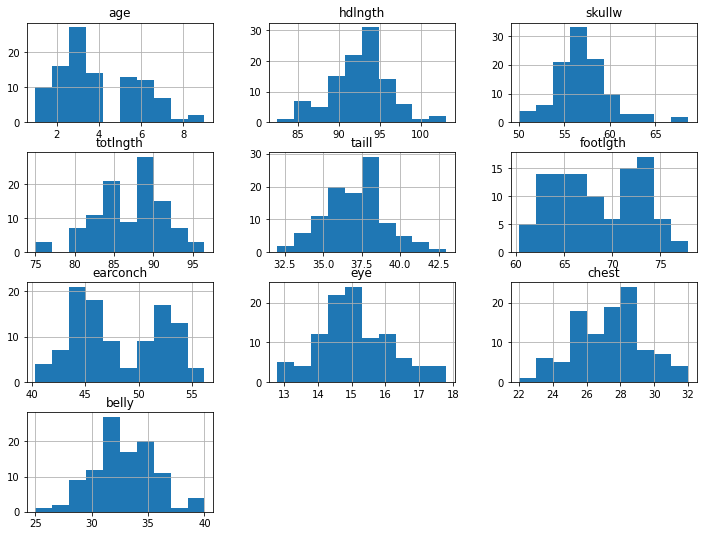

In [17]:
df.hist(figsize=(12,9))

Histograms show us that we shouldn't really be concerned about aspects such as: attributes of very different scales or tail heavy data. However, we will take a better look at these histograms later, during preprocessing process. Additionally, we can see that data doesn't contain outliers, what is one of the factors in favor of changing rmse to another performance measure.

<h3> Test set and training set </h3>

Now, let's check if any of attributes is highly correlated with dependent variable. 

In [18]:
corr_matrix = df.corr()
corr_matrix["age"].sort_values(ascending=False)

age         1.000000
belly       0.354298
chest       0.334209
hdlngth     0.319022
skullw      0.285107
totlngth    0.260280
eye         0.235553
footlgth    0.126190
taill       0.118241
earconch    0.053405
Name: age, dtype: float64

No, there is no high correlation, so we don't need to be aware of sampling bias using standard random sampling.

In [19]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

Now we put test_set aside and start working on train_set only.

<h2> Discover and visualize </h2>

<h3> Histograms </h3>

At first, let's deduce something from histograms of the train_set.

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'hdlngth'}>,
        <AxesSubplot:title={'center':'skullw'}>],
       [<AxesSubplot:title={'center':'totlngth'}>,
        <AxesSubplot:title={'center':'taill'}>,
        <AxesSubplot:title={'center':'footlgth'}>],
       [<AxesSubplot:title={'center':'earconch'}>,
        <AxesSubplot:title={'center':'eye'}>,
        <AxesSubplot:title={'center':'chest'}>],
       [<AxesSubplot:title={'center':'belly'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

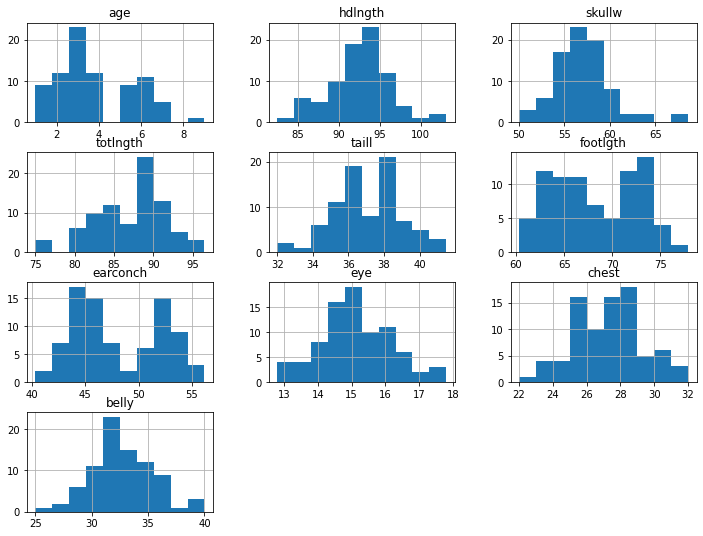

In [20]:
train_set.hist(figsize=(12,9))

Wasserstein distance is a metric in the space of probability measures, which can measure distance between histograms.

In [21]:
columns = train_set.columns

for i in range(len(train_set.columns)):
    if is_numeric_dtype(train_set[train_set.columns[i]]):
        for j in range(i+1,len(train_set.columns)):
            if is_numeric_dtype(train_set[train_set.columns[j]]):
                print('For ', train_set.columns[i], ' and ', train_set.columns[j], 'Wasserstein distance is ', wasserstein_distance(train_set[train_set.columns[i]], train_set[train_set.columns[j]]) )

For  age  and  hdlngth Wasserstein distance is  nan
For  age  and  skullw Wasserstein distance is  nan
For  age  and  totlngth Wasserstein distance is  nan
For  age  and  taill Wasserstein distance is  nan
For  age  and  footlgth Wasserstein distance is  nan
For  age  and  earconch Wasserstein distance is  nan
For  age  and  eye Wasserstein distance is  nan
For  age  and  chest Wasserstein distance is  nan
For  age  and  belly Wasserstein distance is  nan
For  hdlngth  and  skullw Wasserstein distance is  35.628915662650606
For  hdlngth  and  totlngth Wasserstein distance is  5.381927710843373
For  hdlngth  and  taill Wasserstein distance is  55.46265060240963
For  hdlngth  and  footlgth Wasserstein distance is  nan
For  hdlngth  and  earconch Wasserstein distance is  44.42168674698795
For  hdlngth  and  eye Wasserstein distance is  77.43855421686749
For  hdlngth  and  chest Wasserstein distance is  65.55903614457831
For  hdlngth  and  belly Wasserstein distance is  60.046987951807225


Pairs of histograms close to each other are: (hdlngth, totlngth), (taill, belly) and (chest, belly). Potentially we can use this information during feature engineering.

<h3> Correlations </h3>

Let's check a correlation for numeric variables.

In [22]:
train_set.corr()["age"]

age         1.000000
hdlngth     0.254740
skullw      0.192840
totlngth    0.244830
taill       0.098013
footlgth    0.045257
earconch    0.037012
eye         0.220969
chest       0.204392
belly       0.283273
Name: age, dtype: float64

As we can see, correlation levels are very low.

Now, let's check a correlation for categorical attributes (pop, sex, site). Function that we are going to use requires that data has no nans, so let's just drop them for a while.

In [23]:
train_set_new = train_set.copy()

Let's add binary columns that respond columns 'pop' and 'sex'

In [24]:
dummy = pd.get_dummies(train_set_new["pop"])
train_set_new = pd.concat((train_set_new, dummy), axis=1)
del train_set_new["other"]
train_set_new = train_set_new.rename(columns={"Vic":"pop-bin"})

dummy = pd.get_dummies(df["sex"])
train_set_new = pd.concat((train_set_new, dummy), axis=1)
del train_set_new['m']
train_set_new = train_set_new.rename(columns={"f":"sex-bin"})
train_set_new.head()

train_set_new["pop-bin"] = train_set_new["pop-bin"].astype('category')
train_set_new["sex-bin"] = train_set_new["sex-bin"].astype('category')

train_set_new = train_set_new.dropna()
train_set_new.head()

,site,pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,pop-bin,sex-bin
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0,1.0,1
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0,1.0,1
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0,1.0,1
5,1,Vic,f,1.0,93.1,54.8,90.5,35.5,73.2,53.6,14.2,30.0,32.0,1.0,1
6,1,Vic,m,2.0,95.3,58.2,89.5,36.0,71.5,52.0,14.2,30.0,34.5,1.0,0


In [25]:
print(stats.pointbiserialr(train_set_new["pop-bin"], train_set_new["age"]))
print(stats.pointbiserialr(train_set_new["sex-bin"], train_set_new["age"]))

PointbiserialrResult(correlation=0.08370838421598426, pvalue=0.4574990767891822)
PointbiserialrResult(correlation=0.09748964259300605, pvalue=0.38658098861846485)


So even if assumtions of this method are fulfilled, these correlations are not significant.

For a multi categorical attribute we will try ruskal-Wallis H-test.

In [26]:
train_set_new["site"].value_counts()

1    25
7    13
5    11
6    11
2     9
3     6
4     6
Name: site, dtype: int64

In [27]:
group = [None] * 7

for i in range(1,8):
    group[i-1] = train_set_new[["age"]].where(train_set_new["site"] == i).dropna()["age"].tolist()
    print(stats.kruskal(group[i-1], train_set_new["age"]))

KruskalResult(statistic=0.3395172088593224, pvalue=0.5601080307426141)
KruskalResult(statistic=0.1417795109924597, pvalue=0.7065183074614497)
KruskalResult(statistic=0.561735433647231, pvalue=0.4535618539169247)
KruskalResult(statistic=2.005456853621326, pvalue=0.15673406872991036)
KruskalResult(statistic=1.2790622918879813, pvalue=0.2580734590616538)
KruskalResult(statistic=0.008454874681601976, pvalue=0.9267374535850667)
KruskalResult(statistic=1.136838159720179, pvalue=0.28632143298397716)


Since for every group p-value is less than 0.05, we don't reject the null hypothesis that the median of group is same as in train_set for each group. So, we can expect that, site-grouping does not explain the variance to a great extent, hence correlation is low.

<h3> Attribute Combinations </h3>

Since we have only 9 attributes describing possums body, let's just compute ratios between them.

In [28]:
train_set_new = train_set.copy()

body_columns = ['hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']

for i in range(9):
    for j in range(i+1,9):
        new_column = body_columns[i] + " / " + body_columns[j]
        train_set_new[new_column] = train_set_new[body_columns[i]] / train_set_new[body_columns[j]]

In [29]:
corr_matrix = train_set_new.corr()
corr_matrix["age"].sort_values(ascending=False)

age                    1.000000
belly                  0.283273
hdlngth                0.254740
totlngth               0.244830
eye                    0.220969
chest                  0.204392
skullw                 0.192840
totlngth / footlgth    0.162309
totlngth / taill       0.147566
hdlngth / footlgth     0.141474
skullw / footlgth      0.120056
totlngth / earconch    0.099592
taill                  0.098013
hdlngth / earconch     0.087937
skullw / earconch      0.084262
hdlngth / taill        0.083814
skullw / taill         0.081666
footlgth               0.045257
earconch               0.037012
taill / footlgth       0.025634
taill / earconch       0.018716
hdlngth / skullw      -0.024388
skullw / totlngth     -0.024991
totlngth / eye        -0.027085
eye / chest           -0.028092
footlgth / earconch   -0.034156
skullw / eye          -0.051047
hdlngth / totlngth    -0.057181
hdlngth / eye         -0.068390
totlngth / chest      -0.074794
eye / belly           -0.091034
skullw /

Again, correlations are on very low level.

<h2> Prepare the data for ML algorithms </h2>
<h3> Data Cleaning </h3>

In [154]:
train_set_new = train_set.copy()
train_set_new = train_set_new[train_set_new['age'].notna()]
train_set_labels = train_set_new["age"].copy()
train_set_new = train_set_new.drop("age", axis=1)

Since there is only one nan label, we've just dropped it.

Most ML algorithms cannot deal with missing values and we are not sure that there won't be any missing values in new data, let's take a stretegy to replace numerical missing instances with the median of an attribute.

In [155]:
imputer = SimpleImputer(strategy='median')
train_set_new_num = train_set_new.drop(["site", "pop", "sex"], axis=1)
imputer.fit(train_set_new_num)
X = imputer.transform(train_set_new_num)
train_set_new_transformed = pd.DataFrame(X, columns=train_set_new_num.columns)

train_set_new_transformed.isnull().values.any()

False

Since ML algorithms prefer to work with number rather than with categogorical attributes, we will convert them to numerical.

In [156]:
train_set_new_cat = train_set_new[["site", "pop", "sex"]]
cat_encoder = OneHotEncoder()

train_set_new_cat_encoded = cat_encoder.fit_transform(train_set_new_cat)

train_set_new_cat_encoded = train_set_new_cat_encoded.toarray()

In [157]:
cat_encoder.categories_

[array([1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array(['Vic', 'other'], dtype=object),
 array(['f', 'm'], dtype=object)]

Let's create a Pipeline, to hold our transformations in more readable way. Despite the fact that, our data is very good scaled, we can additionaly do standarization, beacuse dataset is very small and it cost almost no time.

In [158]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
    ])

num_attribs = list(train_set_new_num.columns)
cat_attribs = ["site", "pop", "sex"]

pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ("r-skewed", FunctionTransformer(func=np.log1p), ['totlngth', 'belly']),
 ])

Additionally we did appropriate transformation to right skewed features. Now, we will use our transformated data.

In [159]:
train_set_new_ready = pipeline.fit_transform(train_set_new)
train_set_new_ready.shape


(82, 58)

We finished this section with set that contains 58 columns, ready to put into ML algorithm.

<h2> Select and train a model </h2>

In [160]:
import pandas as pd
pd.set_option('display.max_columns', None)

from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import cross_decomposition
from sklearn import ensemble
from sklearn import isotonic
from sklearn.neural_network import MLPRegressor

Our plan is to test as many as possible models, with some different settings, in a short time, then choose a few most promising for hyperparameter tuning, based on rmse measure for training set and cross-validation.

Let's calculate RMSE for training data and mean value of RMSE for Cross-Validation.

<h2> Finding promising models </h2>

<h3> Linear Models </h3>

In [35]:
%%capture --no-display
result_lm = regression_linear_models(train_set_new_ready, train_set_labels, cv=4)
result_lm = pd.DataFrame.from_dict(result_lm)
result_lm

,ARDRegression{},BayesianRidge{},ElasticNet{'selection': 'cyclic'},ElasticNet{'selection': 'random'},HuberRegressor{},Lars{},Lasso{'selection': 'cyclic'},Lasso{'selection': 'random'},LassoLars{},LinearRegression{},"LogisticRegression{'penalty': 'l1', 'solver': 'liblinear'}","LogisticRegression{'penalty': 'l1', 'solver': 'saga'}","LogisticRegression{'penalty': 'l2', 'solver': 'newton-cg'}","LogisticRegression{'penalty': 'l2', 'solver': 'lbfgs'}","LogisticRegression{'penalty': 'l2', 'solver': 'liblinear'}","LogisticRegression{'penalty': 'l2', 'solver': 'sag'}","LogisticRegression{'penalty': 'l2', 'solver': 'saga'}","LogisticRegression{'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.5}","LogisticRegression{'penalty': 'none', 'solver': 'newton-cg'}","LogisticRegression{'penalty': 'none', 'solver': 'lbfgs'}","LogisticRegression{'penalty': 'none', 'solver': 'sag'}","LogisticRegression{'penalty': 'none', 'solver': 'saga'}",OrthogonalMatchingPursuit{},PassiveAggressiveRegressor{'loss': 'epsilon_insensitive'},PassiveAggressiveRegressor{'loss': 'squared_epsilon_insensitive'},RANSACRegressor{},Ridge{'solver': 'svd'},Ridge{'solver': 'cholesky'},Ridge{'solver': 'lsqr'},Ridge{'solver': 'sparse_cg'},Ridge{'solver': 'sag'},Ridge{'solver': 'saga'},"SGDRegressor{'penalty': 'l1', 'learning_rate': 'constant'}","SGDRegressor{'penalty': 'l1', 'learning_rate': 'optimal'}","SGDRegressor{'penalty': 'l1', 'learning_rate': 'invscaling'}","SGDRegressor{'penalty': 'l1', 'learning_rate': 'adaptive'}","SGDRegressor{'penalty': 'l2', 'learning_rate': 'constant'}","SGDRegressor{'penalty': 'l2', 'learning_rate': 'optimal'}","SGDRegressor{'penalty': 'l2', 'learning_rate': 'invscaling'}","SGDRegressor{'penalty': 'l2', 'learning_rate': 'adaptive'}","SGDRegressor{'penalty': 'elasticnet', 'learning_rate': 'adaptive'}",TheilSenRegressor{},TweedieRegressor{'link': 'identity'},TweedieRegressor{'link': 'log'}
rmse_training,1.500612,1.720985,1.807324,1.807324,1.275551,72.090142,1.809692,1.809692,1.809692,0.850896,1.678414,1.728527,1.542092,1.542092,1.530184,1.542092,1.649094,1.637964,0.000000,0.594692,1.444080,1.485704,1.570558,2.043614,2.612285,2.601949,1.390836,1.390836,1.391946,1.390878,1.404288,1.417763,1.890971,4.681458e+13,1.587441,1.469083,2.353110,1.172988e+14,1.632409,1.497848,1.454201,1.070829,1.639399,1.524623
rmse_cv,1.936501,1.849728,1.854198,1.854542,2.580660,13222.012598,1.844538,1.844538,1.844538,8.022427,1.986954,2.064786,2.362686,2.362686,2.156346,2.246902,2.246902,2.179860,2.738958,2.357410,2.554081,2.393976,1.945627,2.294083,2.186708,15.167141,2.012011,2.012011,2.009908,2.012133,2.012058,2.009161,2.787248,1.011803e+14,1.948427,1.995468,2.293446,8.042401e+13,1.944068,1.950731,1.952146,8.693768,1.851942,2.114590


<h3> KernelRidge </h3>

In [53]:
%%capture --no-display
result_kr = regression_kernelridge(train_set_new_ready, train_set_labels, cv=4)
result_kr = pd.DataFrame.from_dict(result_kr)
result_kr

,KernelRidge 1**2,KernelRidge DotProduct(sigma_0=1),"KernelRidge ExpSineSquared(length_scale=1, periodicity=1)","KernelRidge Matern(length_scale=1, nu=1.5)","KernelRidge PairwiseKernel(gamma=1.0, metric=linear)","KernelRidge RationalQuadratic(alpha=1, length_scale=1)",KernelRidge RBF(length_scale=1),KernelRidge WhiteKernel(noise_level=1),KernelRidge linear
rmse_training,1.810247,1.390653,3.318812,2.023938,1.390648,1.218348,2.055960,4.136394,1.390648
rmse_cv,1.842443,2.011974,15.776251,4.042328,2.011973,2.578366,4.083858,4.099670,2.011973


<h3> SVM </h3>

In [54]:
%%capture --no-display
result_svm = regression_svm(train_set_new_ready, train_set_labels, cv=4)
result_svm = pd.DataFrame.from_dict(result_svm)
result_svm

,LinearSVR{'loss': 'epsilon_insensitive'},LinearSVR{'loss': 'squared_epsilon_insensitive'},NuSVR{'kernel': 'linear'},NuSVR{'kernel': 'poly'},NuSVR{'kernel': 'rbf'},NuSVR{'kernel': 'sigmoid'},SVR{'kernel': 'linear'},SVR{'kernel': 'poly'},SVR{'kernel': 'rbf'},SVR{'kernel': 'sigmoid'}
rmse_training,1.500873,1.343088,1.476317,1.377438,1.481749,1.837184,1.496323,1.43371,1.489761,1.877357
rmse_cv,2.166390,2.052075,1.916470,1.770307,1.742634,1.851783,2.133088,1.82145,1.720149,1.933953


<h3> Gaussian Process </h3>

In [55]:
%%capture --no-display
result_gpr = regression_gaussianprocess(train_set_new_ready, train_set_labels, cv=4)
result_gpr = pd.DataFrame.from_dict(result_gpr)
result_gpr

,GaussianProcessRegressor 1**2,GaussianProcessRegressor DotProduct(sigma_0=1),"GaussianProcessRegressor Matern(length_scale=1, nu=1.5)","GaussianProcessRegressor PairwiseKernel(gamma=1.0, metric=linear)","GaussianProcessRegressor RationalQuadratic(alpha=1, length_scale=1)",GaussianProcessRegressor RBF(length_scale=1),GaussianProcessRegressor WhiteKernel(noise_level=1)
rmse_training,1.809692,0.850870,3.182825e-10,0.851026,2.213020e-10,4.607285e-10,4.136394
rmse_cv,3.456524,8.021744,1.773059e+00,8.021249,1.705117e+00,2.039888e+00,4.099670


<h3> Cross Decomposition </h3>

In [56]:
%%capture --no-display
result_cd = regression_crossdecomposition(train_set_new_ready, train_set_labels, cv=4)
result_cd = pd.DataFrame.from_dict(result_cd)
result_cd

,CCA{},PLSCanonical{'algorithm': 'nipals'},PLSCanonical{'algorithm': 'svd'},PLSRegression{}
rmse_training,1.788298,4.701129,4.701129,1.586375
rmse_cv,1.841178,4.974416,4.974416,1.890073


<h3> Decision Tree </h3>

In [57]:
result_tree = regression_decisiontree(train_set_new_ready, train_set_labels, cv=4)
result_tree = pd.DataFrame.from_dict(result_tree)
result_tree

,"DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': None}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': None}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'best', 'max_features': None}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'best', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'best', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'best', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'random', 'max_features': None}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'random', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'random', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'random', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'best', 'max_features': None}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'best', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'best', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'best', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'random', 'max_features': None}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'random', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'random', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'random', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'best', 'max_features': None}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'best', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'best', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'best', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'random', 'max_features': None}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'random', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'random', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'random', 'max_features': 'log2'}"
rmse_training,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
rmse_cv,2.233843,2.271042,2.212846,2.183563,2.478414,2.767762,2.531771,2.25333,2.210463,2.267652,2.33212,2.106171,2.229213,2.398755,2.500572,2.412046,2.464264,2.213631,2.50611,2.181833,2.439564,2.138197,2.323329,2.685324,2.75459,2.602973,2.543508,2.540274,2.624218,2.472819,2.444517,2.495016


<h3> Ensemble Methods </h3>

In [58]:
%%capture --no-display
from sklearn import ensemble
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor

result_ens = regression_ensemble(train_set_new_ready, train_set_labels, cv=4)
result_ens = pd.DataFrame.from_dict(result_ens)
result_ens

,AdaBoostRegressor{'loss': 'linear'},AdaBoostRegressor{'loss': 'square'},AdaBoostRegressor{'loss': 'exponential'},BaggingRegressor{},"ExtraTreesRegressor{'criterion': 'mse', 'max_features': 'sqrt'}","ExtraTreesRegressor{'criterion': 'mae', 'max_features': 'sqrt'}","ExtraTreesRegressor{'criterion': 'mse', 'max_features': 'log2'}","ExtraTreesRegressor{'criterion': 'mae', 'max_features': 'log2'}","ExtraTreesRegressor{'criterion': 'mse', 'max_features': None}","ExtraTreesRegressor{'criterion': 'mae', 'max_features': None}","ExtraTreesRegressor{'criterion': 'mse', 'max_features': 1}","ExtraTreesRegressor{'criterion': 'mae', 'max_features': 1}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'ls', 'max_features': None}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'ls', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'ls', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'ls', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'lad', 'max_features': None}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'lad', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'lad', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'lad', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'huber', 'max_features': None}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'huber', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'huber', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'huber', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'quantile', 'max_features': None}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'quantile', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'quantile', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'quantile', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'ls', 'max_features': None}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'ls', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'ls', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'ls', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'lad', 'max_features': None}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'lad', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'lad', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'lad', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'huber', 'max_features': None}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'huber', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'huber', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'huber', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'quantile', 'max_features': None}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'quantile', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'quantile', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'quantile', 'max_features': 'log2'}",IsolationForest{},"RandomForestRegressor{'criterion': 'mse', 'max_features': 'sqrt'}","RandomForestRegressor{'criterion': 'mse', 'max_features': 'log2'}","RandomForestRegressor{'criterion': 'mse', 'max_features': None}","RandomForestRegressor{'criterion': 'mse', 'max_features': 1}","RandomForestRegressor{'criterion': 'mae', 'max_features': 'sqrt'}","RandomForestRegressor{'criterion': 'mae',

<h3> Neural Network </h3>

In [59]:
%%capture --no-display
regression_neuralnetwork
result_nn = regression_neuralnetwork(train_set_new_ready, train_set_labels, cv=4)
result_nn = pd.DataFrame.from_dict(result_nn)
result_nn

,"MLPRegressor {'activation': 'identity', 'learning_rate': 'constant', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'constant', 'solver': 'sgd'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'constant', 'solver': 'adam'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'invscaling', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'invscaling', 'solver': 'sgd'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'invscaling', 'solver': 'adam'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'adaptive', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'adaptive', 'solver': 'sgd'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'adaptive', 'solver': 'adam'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'constant', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'constant', 'solver': 'sgd'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'constant', 'solver': 'adam'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'invscaling', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'invscaling', 'solver': 'sgd'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'invscaling', 'solver': 'adam'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'adaptive', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'adaptive', 'solver': 'sgd'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'adaptive', 'solver': 'adam'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'constant', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'constant', 'solver': 'sgd'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'constant', 'solver': 'adam'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'invscaling', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'invscaling', 'solver': 'sgd'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'invscaling', 'solver': 'adam'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'adaptive', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'adaptive', 'solver': 'sgd'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'adaptive', 'solver': 'adam'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'constant', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'constant', 'solver': 'sgd'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'constant', 'solver': 'adam'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'invscaling', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'invscaling', 'solver': 'sgd'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'invscaling', 'solver': 'adam'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'adaptive', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'adaptive', 'solver': 'sgd'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'adaptive', 'solver': 'adam'}"
rmse_training,1.110997,1.540442,1.714567,1.092933,2.230803,1.796151,1.109937,1.537323,1.704259,0.001391,1.902836,1.468405,0.002105,2.108634,1.462730,0.000876,1.790982,1.472237,0.000514,1.159269,0.727872,0.000968,1.832320,0.704637,0.000414,1.137023,0.796294,0.000730,1.20581,0.768564,0.000521,1.739974,0.596877,0.000647,1.642388,0.557992
rmse_cv,2.546353,1.954729,2.063249,2.568573,2.036573,2.024734,2.556467,1.933823,2.055150,2.188122,1.988777,1.892070,2.303547,2.014445,1.875351,2.160220,1.816630,1.882380,2.316952,1.879775,1.945397,2.302232,1.950482,1.985905,2.428734,1.847557,1.998403,2.317594,1.90734,1.841177,2.319088,1.831010,1.813912,2.063213,1.777582,1.839730


<h3> Summary </h3>

In [60]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
result = pd.concat([result_lm, result_kr, result_svm, result_gpr, result_cd, result_tree, result_ens, result_nn] , axis=1)
result

,ARDRegression{},BayesianRidge{},ElasticNet{'selection': 'cyclic'},ElasticNet{'selection': 'random'},HuberRegressor{},Lars{},Lasso{'selection': 'cyclic'},Lasso{'selection': 'random'},LassoLars{},LinearRegression{},"LogisticRegression{'penalty': 'l1', 'solver': 'liblinear'}","LogisticRegression{'penalty': 'l1', 'solver': 'saga'}","LogisticRegression{'penalty': 'l2', 'solver': 'newton-cg'}","LogisticRegression{'penalty': 'l2', 'solver': 'lbfgs'}","LogisticRegression{'penalty': 'l2', 'solver': 'liblinear'}","LogisticRegression{'penalty': 'l2', 'solver': 'sag'}","LogisticRegression{'penalty': 'l2', 'solver': 'saga'}","LogisticRegression{'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.5}","LogisticRegression{'penalty': 'none', 'solver': 'newton-cg'}","LogisticRegression{'penalty': 'none', 'solver': 'lbfgs'}","LogisticRegression{'penalty': 'none', 'solver': 'sag'}","LogisticRegression{'penalty': 'none', 'solver': 'saga'}",OrthogonalMatchingPursuit{},PassiveAggressiveRegressor{'loss': 'epsilon_insensitive'},PassiveAggressiveRegressor{'loss': 'squared_epsilon_insensitive'},RANSACRegressor{},Ridge{'solver': 'svd'},Ridge{'solver': 'cholesky'},Ridge{'solver': 'lsqr'},Ridge{'solver': 'sparse_cg'},Ridge{'solver': 'sag'},Ridge{'solver': 'saga'},"SGDRegressor{'penalty': 'l1', 'learning_rate': 'constant'}","SGDRegressor{'penalty': 'l1', 'learning_rate': 'optimal'}","SGDRegressor{'penalty': 'l1', 'learning_rate': 'invscaling'}","SGDRegressor{'penalty': 'l1', 'learning_rate': 'adaptive'}","SGDRegressor{'penalty': 'l2', 'learning_rate': 'constant'}","SGDRegressor{'penalty': 'l2', 'learning_rate': 'optimal'}","SGDRegressor{'penalty': 'l2', 'learning_rate': 'invscaling'}","SGDRegressor{'penalty': 'l2', 'learning_rate': 'adaptive'}","SGDRegressor{'penalty': 'elasticnet', 'learning_rate': 'adaptive'}",TheilSenRegressor{},TweedieRegressor{'link': 'identity'},TweedieRegressor{'link': 'log'},KernelRidge 1**2,KernelRidge DotProduct(sigma_0=1),"KernelRidge ExpSineSquared(length_scale=1, periodicity=1)","KernelRidge Matern(length_scale=1, nu=1.5)","KernelRidge PairwiseKernel(gamma=1.0, metric=linear)","KernelRidge RationalQuadratic(alpha=1, length_scale=1)",KernelRidge RBF(length_scale=1),KernelRidge WhiteKernel(noise_level=1),KernelRidge linear,LinearSVR{'loss': 'epsilon_insensitive'},LinearSVR{'loss': 'squared_epsilon_insensitive'},NuSVR{'kernel': 'linear'},NuSVR{'kernel': 'poly'},NuSVR{'kernel': 'rbf'},NuSVR{'kernel': 'sigmoid'},SVR{'kernel': 'linear'},SVR{'kernel': 'poly'},SVR{'kernel': 'rbf'},SVR{'kernel': 'sigmoid'},GaussianProcessRegressor 1**2,GaussianProcessRegressor DotProduct(sigma_0=1),"GaussianProcessRegressor Matern(length_scale=1, nu=1.5)","GaussianProcessRegressor PairwiseKernel(gamma=1.0, metric=linear)","GaussianProcessRegressor RationalQuadratic(alpha=1, length_scale=1)",GaussianProcessRegressor RBF(length_scale=1),GaussianProcessRegressor WhiteKernel(noise_level=1),CCA{},PLSCanonical{'algorithm': 'nipals'},PLSCanonical{'algorithm': 'svd'},PLSRegression{},"DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': None}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': None}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'best', 'max_features': None}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'best', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'best', 'max_fea

Somehow we have to decide to continue working with a few models. The models aren't good at the moment. Some of them overfits (cv error is high, training error low), when others underfit (validation and training error high) data. In fact, we don't want to prevent underfitting yet. To do it we should select model with more parameters (we've tested a lot of models), find better features (we've done some attribute combinations) or reduce regularization hyperparameter, what is harder than try to prevent overfitting in other models. At first, we will prevent oferfitting by reducing the number of attributes in the training data for a few models with best rmse_cv result.

In [61]:
result.loc['rmse_cv'].sort_values().head(30)

ExtraTreesRegressor{'criterion': 'mse', 'max_features': 1}                                         1.662910
ExtraTreesRegressor{'criterion': 'mse', 'max_features': 'log2'}                                    1.668885
ExtraTreesRegressor{'criterion': 'mse', 'max_features': 'sqrt'}                                    1.669964
ExtraTreesRegressor{'criterion': 'mae', 'max_features': 'log2'}                                    1.678114
RandomForestRegressor{'criterion': 'mse', 'max_features': None}                                    1.694973
GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'huber', 'max_features': 'sqrt'}    1.698285
RandomForestRegressor{'criterion': 'mse', 'max_features': 'log2'}                                  1.700438
GradientBoostingRegressor{'criterion': 'mse', 'loss': 'huber', 'max_features': 'auto'}             1.701336
ExtraTreesRegressor{'criterion': 'mae', 'max_features': 1}                                         1.701542
RandomForestRegressor{'crite

Assuming our approach, let's prevent overfitting for GradientBoostingRegressor, ExtraTreesRegressor and RandomForestRegressor.

<h2> Fine-tuning </h2>

<h3> GradientBoostingRegressor </h3>
<h4> Feature Selection </h4>

I've tested GradientBoosting from sklearn and from xgboost and preformance of model from xgboost module was much better, so I'will use XGBRegressor for better performance, even though tuning'll be more difficult.

At first, I will find importance of each feature for the algorithm

Feature: 0, Score: 0.06029
Feature: 1, Score: 0.02061
Feature: 2, Score: 0.00414
Feature: 3, Score: 0.00146
Feature: 4, Score: 0.00931
Feature: 5, Score: 0.00120
Feature: 6, Score: 0.00188
Feature: 7, Score: 0.04344
Feature: 8, Score: 0.00167
Feature: 9, Score: 0.01399
Feature: 10, Score: 0.00176
Feature: 11, Score: 0.00054
Feature: 12, Score: 0.01152
Feature: 13, Score: 0.00095
Feature: 14, Score: 0.00169
Feature: 15, Score: 0.05705
Feature: 16, Score: 0.00108
Feature: 17, Score: 0.00100
Feature: 18, Score: 0.01185
Feature: 19, Score: 0.01773
Feature: 20, Score: 0.00560
Feature: 21, Score: 0.00045
Feature: 22, Score: 0.02307
Feature: 23, Score: 0.00156
Feature: 24, Score: 0.02694
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00001
Feature: 27, Score: 0.02445
Feature: 28, Score: 0.05424
Feature: 29, Score: 0.00049
Feature: 30, Score: 0.00146
Feature: 31, Score: 0.02624
Feature: 32, Score: 0.00004
Feature: 33, Score: 0.01105
Feature: 34, Score: 0.00013
Feature: 35, Score: 0.00065
Fe

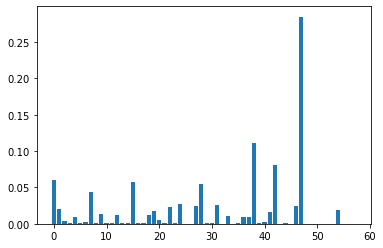

In [140]:
# This part of code is from machinelearningmastery.com
from xgboost import XGBRegressor
import xgboost

X, y = train_set_new_ready, train_set_labels

model = XGBRegressor()

model.fit(X, y)

importance = model.feature_importances_

gbr_importance = []

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    gbr_importance.append(v)
    
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Let's choose the feature, which has best importance and train the model.

In [141]:
gbr_features = np.argsort(gbr_importance)[-1:]

model = XGBRegressor()
model.fit(X[:,gbr_features], y)
predictions = model.predict(X[:,gbr_features])
train_mse = mean_squared_error(predictions, y)
rmse_training = np.sqrt(train_mse)
print(rmse_training)

scores = cross_val_score(model, train_set_new_ready, np.ravel(train_set_labels),
                              scoring="neg_mean_squared_error", cv=4)

rmse_cv = np.sqrt(-scores).mean()
print(rmse_cv)

1.8053254102355303
1.708771909207174


array([47], dtype=int64)

As we can see, now model is underfitting. Let's add one more feature.

In [154]:
gbr_features = np.argsort(gbr_importance)[-2:]

model = XGBRegressor()
model.fit(X[:,gbr_features], y)
predictions = model.predict(X[:,gbr_features])
train_mse = mean_squared_error(predictions, y)
rmse_training = np.sqrt(train_mse)
print(rmse_training)

scores = cross_val_score(model, train_set_new_ready, np.ravel(train_set_labels),
                              scoring="neg_mean_squared_error", cv=4)

rmse_cv = np.sqrt(-scores).mean()
print(rmse_cv)

0.08084225097899564
1.708771909207174


array([38, 47], dtype=int64)

This time, model is overfitting. Now, let's do a grid search for both models.

<h4> Randomized Search </h4>

min_samples_split
Defines the minimum number of samples (or observations) which are required in a node to be considered for splitting.
Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
Too high values can lead to under-fitting hence, it should be tuned using CV.
min_samples_leaf
Defines the minimum samples (or observations) required in a terminal node or leaf.
Used to control over-fitting similar to min_samples_split.
Generally lower values should be chosen for imbalanced class problems because the regions in which the minority class will be in majority will be very small.
min_weight_fraction_leaf
Similar to min_samples_leaf but defined as a fraction of the total number of observations instead of an integer.
Only one of #2 and #3 should be defined.
max_depth
The maximum depth of a tree.
Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
Should be tuned using CV.
max_leaf_nodes
The maximum number of terminal nodes or leaves in a tree.
Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
If this is defined, GBM will ignore max_depth.
max_features
The number of features to consider while searching for a best split. These will be randomly selected.
As a thumb-rule, square root of the total number of features works great but we should check upto 30-40% of the total number of features.
Higher values can lead to over-fitting but depends on case to case.

In [143]:
%%capture --no-display
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

# distributions = { 'n_estimators': randint(3,9),
#                   'learning_rate': uniform(loc=0.01, scale=0.55),
#                   'tree_method': [None, 'exact', 'approx', 'hist'],
#                   'booster': [None, 'gbtree', 'gblinear', 'dart'],
#                   'gamma': uniform(loc=0.01, scale=1.2),
#                   'grow_policy': [None, 'depthwise', 'lossguide'],
#                   'n_jobs': randint(1,9),
#                   'min_child_weight': uniform(loc=0.01, scale=0.65),
#                   'colsample_bytree': uniform(loc=0.3, scale=0.7),
#                   'colsample_bylevel': uniform(loc=0.3, scale=0.7),
#                   'colsample_bynode': uniform(loc=0.2, scale=0.7),
#                   'reg_alpha': uniform(loc=0.1, scale=3)
                 
#                 }

distributions = { 'learning_rate':[0.1], # typowo 0.1 moze byc generalnie z przedzialu 0.05-0.2 
                  'n_estimators': randint(20,21), # typowo jest 40-70
                  'max_depth': [5], # typowo jest 5-8
                  'subsample': [0.8], # 0.8 is commonly used
                }


gbr_features = np.argsort(gbr_importance)[-2:]

model = XGBRegressor()
reg = RandomizedSearchCV(model, distributions, n_iter=2, random_state=42)

reg.fit(X[:,gbr_features], y)

predictions = reg.predict(X[:,gbr_features])
train_mse = mean_squared_error(predictions, y)
rmse_training = np.sqrt(train_mse)

scores = cross_val_score(reg, train_set_new_ready, np.ravel(train_set_labels),
                              scoring="neg_mean_squared_error", cv=4)

rmse_cv = np.sqrt(-scores).mean()

array([38, 47], dtype=int64)

In [144]:
print(reg.best_params_)
print(rmse_training)
print(rmse_cv)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 20, 'subsample': 0.8}
1.3541963580952017
1.7473603230135484


Feature: 0, Score: 0.67833
Feature: 1, Score: 0.32167


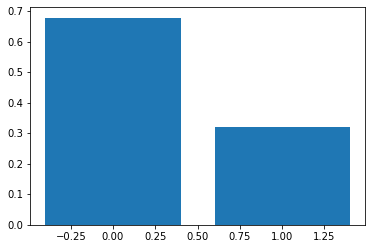

In [145]:
importance = reg.best_estimator_.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

We can see, features get more importance, so let's test our model with more features.

<h4> 3 features </h4>

In [155]:
gbr_features = np.argsort(gbr_importance)[-3:]

distributions = { 'learning_rate':[0.1], # typowo 0.1 moze byc generalnie z przedzialu 0.05-0.2 
                  'n_estimators': randint(20,21), # typowo jest 40-70
                  'max_depth': [5], # typowo jest 5-8
                  'subsample': [0.8], # 0.8 is commonly used
                }




model = XGBRegressor()
reg = RandomizedSearchCV(model, distributions, n_iter=2, random_state=42)

reg.fit(X[:,gbr_features], y)

predictions = reg.predict(X[:,gbr_features])
train_mse = mean_squared_error(predictions, y)
rmse_training = np.sqrt(train_mse)

scores = cross_val_score(reg, train_set_new_ready, np.ravel(train_set_labels),
                              scoring="neg_mean_squared_error", cv=4)

rmse_cv = np.sqrt(-scores).mean()


array([42, 38, 47], dtype=int64)

In [156]:
print(reg.best_params_)
print(rmse_training)
print(rmse_cv)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 20, 'subsample': 0.8}
1.1590957727835844
1.7473603230135484


array([42, 38, 47], dtype=int64)

Feature: 0, Score: 0.35991
Feature: 1, Score: 0.64009
Feature: 2, Score: 0.00000


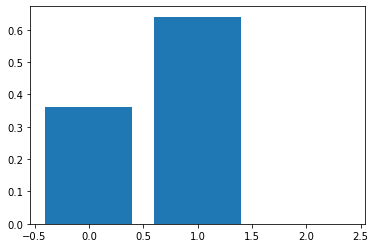

In [148]:
importance = reg.best_estimator_.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

<h4> 4 features </h4>

In [149]:
gbr_features = np.argsort(gbr_importance)[-4:]

distributions = { 'learning_rate':[0.1], # typowo 0.1 moze byc generalnie z przedzialu 0.05-0.2 
                  'n_estimators': randint(20,21), # typowo jest 40-70
                  'max_depth': [5], # typowo jest 5-8
                  'subsample': [0.8], # 0.8 is commonly used
                }




model = XGBRegressor()
reg = RandomizedSearchCV(model, distributions, n_iter=2, random_state=42)

reg.fit(X[:,gbr_features], y)

predictions = reg.predict(X[:,gbr_features])
train_mse = mean_squared_error(predictions, y)
rmse_training = np.sqrt(train_mse)

scores = cross_val_score(reg, train_set_new_ready, np.ravel(train_set_labels),
                              scoring="neg_mean_squared_error", cv=4)

rmse_cv = np.sqrt(-scores).mean()

In [150]:
print(reg.best_params_)
print(rmse_training)
print(rmse_cv)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 20, 'subsample': 0.8}
0.9579228378415066
1.7473603230135484


Feature: 0, Score: 0.41099
Feature: 1, Score: 0.21903
Feature: 2, Score: 0.26392
Feature: 3, Score: 0.10606


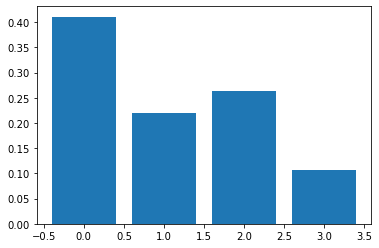

In [151]:
importance = reg.best_estimator_.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
Mozliwe ze trzeba zaczac od wszystkich ficzerow ???? i dodawac tak jak w poradniku...
Mozliwe ze trzeba zaczac od wszystkich ficzerow ???? i dodawac tak jak w poradniku...
Mozliwe ze trzeba zaczac od wszystkich ficzerow ???? i dodawac tak jak w poradniku...
Mozliwe ze trzeba zaczac od wszystkich ficzerow ???? i dodawac tak jak w poradniku...
Mozliwe ze trzeba zaczac od wszystkich ficzerow ???? i dodawac tak jak w poradniku...
Mozliwe ze trzeba zaczac od wszystkich ficzerow ???? i dodawac tak jak w poradniku...

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
LECIMY Z TEGO LINKUUUUUUUUUUUUUUUU

In [36]:
gbr_features = np.argsort(gbr_importance)[:]

distributions = { 'learning_rate':[0.1], # 0.1 is a good value to start with, generally use sth in 0.05-0.3
                  'n_estimators': [33], # typowo jest 40-70
                  'max_depth': [5], # 5-8
                  'min_child_weight': [1], # dataset is very small
                  'gamma': [0], # good value to start is 0, also in 0.1 to 0.2
                  'subsample': [0.8], # value to start should be in 0.5-0.9
                  'colsample_bytree': [0.8], # value to start should be in 0.5-0.9
                 
                }




model = XGBRegressor()
reg = RandomizedSearchCV(model, distributions, n_iter=61, random_state=42)

reg.fit(X[:,gbr_features], y)

predictions = reg.predict(X[:,gbr_features])
train_mse = mean_squared_error(predictions, y)
rmse_training = np.sqrt(train_mse)

scores = cross_val_score(reg, train_set_new_ready, np.ravel(train_set_labels),
                              scoring="neg_mean_squared_error", cv=4)

rmse_cv = np.sqrt(-scores).mean()

Audio(sound_file, autoplay=True)

NameError: name 'gbr_importance' is not defined

In [170]:
print(reg.best_params_)
print(rmse_training)
print(rmse_cv)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 33, 'subsample': 0.8}
0.40678075938484787
1.6578379026849261


Feature: 0, Score: 0.00175
Feature: 1, Score: 0.00083
Feature: 2, Score: 0.01962
Feature: 3, Score: 0.00199
Feature: 4, Score: 0.00219
Feature: 5, Score: 0.00009
Feature: 6, Score: 0.00179
Feature: 7, Score: 0.00100
Feature: 8, Score: 0.01574
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00367
Feature: 11, Score: 0.00298
Feature: 12, Score: 0.00558
Feature: 13, Score: 0.00736
Feature: 14, Score: 0.00377
Feature: 15, Score: 0.03381
Feature: 16, Score: 0.01115
Feature: 17, Score: 0.00616
Feature: 18, Score: 0.00517
Feature: 19, Score: 0.01327
Feature: 20, Score: 0.01914
Feature: 21, Score: 0.02657
Feature: 22, Score: 0.00299
Feature: 23, Score: 0.01162
Feature: 24, Score: 0.02494
Feature: 25, Score: 0.01049
Feature: 26, Score: 0.00569
Feature: 27, Score: 0.00572
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00880
Feature: 30, Score: 0.01126
Feature: 31, Score: 0.01830
Feature: 32, Score: 0.00669
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.02322
Feature: 35, Score: 0.01537
Fe

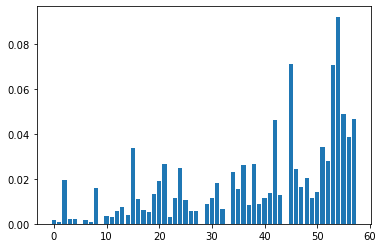

In [171]:
importance = reg.best_estimator_.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

<h2> Bibliography </h2>

https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365

https://scikit-learn.org/stable/supervised_learning.html

https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error

https://www.analyticsvidhya.com/blog/2021/05/feature-transformations-in-data-science-a-detailed-walkthrough/

https://machinelearningmastery.com/calculate-feature-importance-with-python/

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/